Using KMeans to cluster the customers based on their account activity, and then examine the demographic data of each group to see if they differ in a meaningful way.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df=pd.read_csv('BankChurners.csv')

In [3]:
del df['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1']
del df['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
df = df.drop(columns = ['CLIENTNUM'])

In [4]:
df.shape

(10127, 20)

Skew Features

In [5]:
# Select numerical variables
numeric = df.select_dtypes(exclude=object).columns

skew_limit = 0.5
skew_vals = df[numeric].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
Total_Ct_Chng_Q4_Q1,2.064031
Total_Trans_Amt,2.041003
Total_Amt_Chng_Q4_Q1,1.732063
Credit_Limit,1.666726
Avg_Open_To_Buy,1.661697
Avg_Utilization_Ratio,0.718008
Months_Inactive_12_mon,0.633061


In our case, we'll use the Box-Cox transformation to transform all the skew features into a normal distribution.

In [6]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Normalize skewed features
for col in skew_cols.index:
   df[col] = np.log1p(df[col])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  float64
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

When using KMeans, we have to specify the number of clusters the algorithm will use. One way to find the ideal number of clusters is the elbow method.

The elbow method allows us to identify at which K value the sum of squared distance, or the distance between data points and their respective centroids, begins to level off.

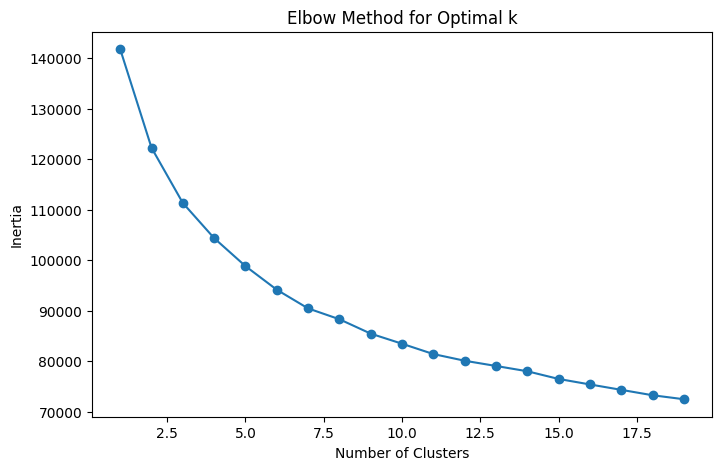

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Cluster
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,3,9.448727,777,9.385553,0.848012,7.043160,42,0.965081,0.059212,3
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,2,9.018817,864,8.908289,0.932558,7.163947,33,1.550537,0.099845,3
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,0,8.137103,0,8.137103,1.279266,7.543273,20,1.203873,0.000000,0
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,1,8.105911,2517,6.680855,0.877550,7.066467,20,1.203873,0.565314,4
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,0,8.458928,0,8.458928,1.155308,6.705639,28,1.252763,0.000000,0


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Choosing numerical columns    
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
data_numeric = df[numeric_columns]

# Standardize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Determine optimal number of clusters
inertia = []
k_range = range(1,20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Graphical representation
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# KMeans clustering
optimal_k = 6  # Elbow method a gore belirlenen kume sayisi 4-6 arasinda olabilir
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Add cluster information to the dataframe
df['Cluster'] = clusters
df.head(5)


Silhouette Score Kullanımı:

For preprocessing, we will first normalize our data, and then perform Principal Component Analysis.

Principal Component Analysis, or PCA, is a method that compresses the information found in the explanatory variables into a reduced number of new variables. This reduces the noise and dimensionality of the data while preserving most of the original information.

In [9]:


preprocessor = Pipeline(
[
 ("scaler", StandardScaler()),
 ("pca", PCA(n_components=2, random_state=1))
]
)

clusterer = Pipeline(
     [
       (
              "kmeans",
               KMeans(
                   n_clusters=6,
                   init="k-means++",
                   n_init=50,
                   max_iter=1000,
                   random_state=1
                      )
       )
      ]
   )
pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )


pipe.fit(df[numeric_columns])
Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=1))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=1000, n_clusters=6, n_init=50,
                                         random_state=1))]))])
print('PCA Component 1 Ratio of Explained Variance')
print(round(preprocessor['pca'].explained_variance_ratio_[0], 2))
print()
print('PCA Component 2 Ratio of Explained Variance')
print(round(preprocessor['pca'].explained_variance_ratio_[1], 2))

PCA Component 1 Ratio of Explained Variance
0.19

PCA Component 2 Ratio of Explained Variance
0.16


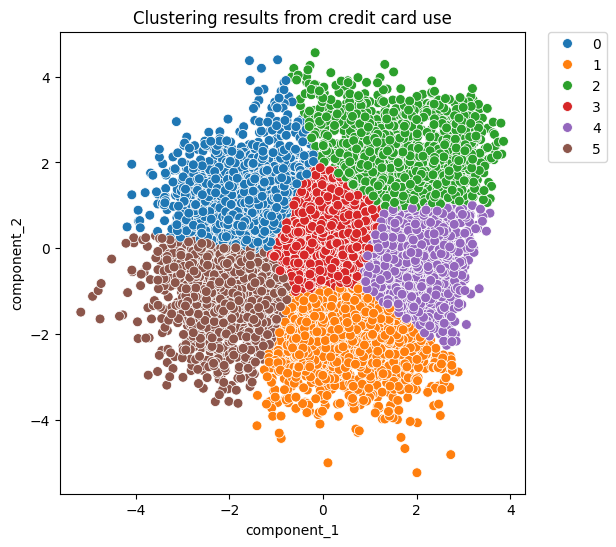

In [10]:
pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(df[numeric_columns]),
        columns=["component_1", "component_2"]
    )
   
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.figure(figsize=(6, 6))
   
sp = sns.scatterplot(
        x="component_1",
        y="component_2",
        s=50,
        data=pcadf,
        hue="predicted_cluster",
        palette='tab10'
    )
   
sp.set_title("Clustering results from credit card use")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()


Examine Differences Between Clusters

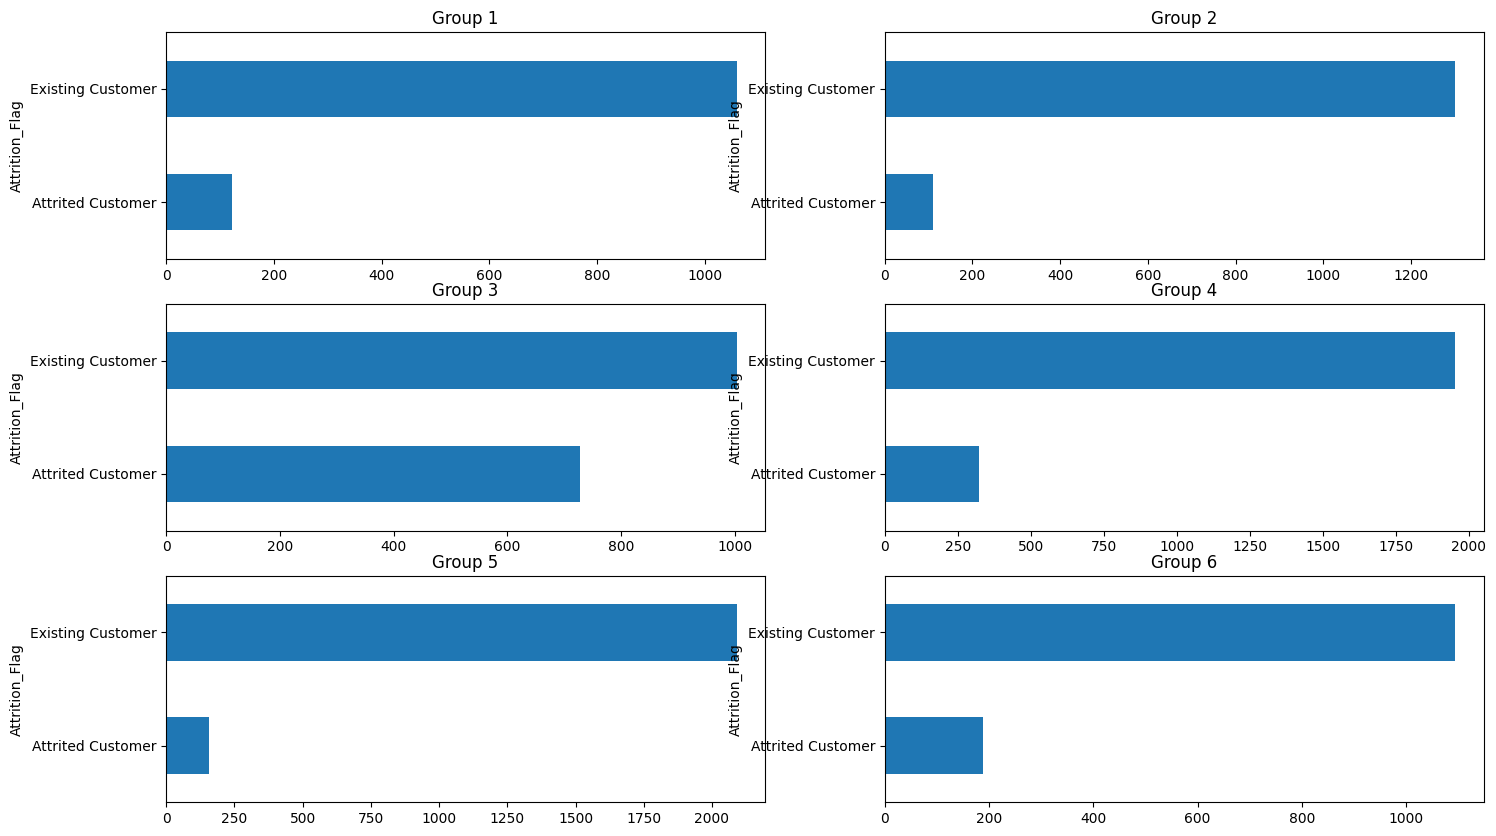

In [11]:
fig, axs = plt.subplots(ncols=2,nrows=3, figsize=(17,10))

df[df['Cluster'] == 0]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[0,0], title='Group 1')
df[df['Cluster'] == 1]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[0,1], title='Group 2')
df[df['Cluster'] == 2]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[1,0], title='Group 3')
df[df['Cluster'] == 3]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[1,1], title='Group 4')
df[df['Cluster'] == 4]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[2,0], title='Group 5')
df[df['Cluster'] == 5]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[2,1], title='Group 6')
plt.show()

In [17]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[numeric_columns]), columns=numeric_columns)
scaled_df['cluster'] = pipe['clusterer']['kmeans'].labels_

Based on the results above, I decided to give the following names to each of the groups:

Group 1: "High Credit Utilizers" – High credit usage and revolving balance:Features like Avg_Utilization_Ratio and Total_Revolving_Bal are highly positive.
This indicates that members of this group actively utilize a significant portion of their available credit.
Credit_Limit and Avg_Open_To_Buy are less prominent, suggesting limited unused credit.

Group 2: "Low Activity Customers" – Minimal transactions and engagement: Most features, including Total_Trans_Amt, Total_Trans_Ct, and Total_Relationship_Count, are negative.
Months_Inactive_12_mon is slightly positive, suggesting inactivity.
This group likely represents customers with minimal banking activity and engagement.

Group 3: "Frequent Small Transaction Users" – Regular, small-scale transactions: Total_Trans_Amt and Total_Trans_Ct are moderately positive, suggesting frequent transactions, but the amounts may not be large.
Avg_Utilization_Ratio is negative, indicating that they do not heavily utilize their credit.
Likely, this group consists of customers who engage in regular but small-scale transactions.

Group 4: "Young and Less Engaged Customers" – Younger, with limited activity: Features like Customer_Age and Dependent_Count are low, suggesting younger customers with potentially fewer family obligations.
Most other features are near zero, indicating limited engagement with financial services or moderate activity levels.

Group 5: "Low Credit Users with Moderate Engagement" – Low credit usage but moderate engagement: Avg_Utilization_Ratio and Total_Revolving_Bal are negative, showing low credit usage.
Avg_Open_To_Buy is positive, indicating they have significant unused credit.
Other features like Total_Relationship_Count and Contacts_Count_12_mon are moderately positive, suggesting reasonable engagement.

Group 6: "Highly Engaged High-Spending Customers" – Active and high-spending individuals: Features like Total_Trans_Amt, Total_Trans_Ct, Credit_Limit, and Avg_Open_To_Buy are strongly positive.
This group represents customers who are actively engaged with their financial services and spend significantly.
Likely high-value customers for the business.

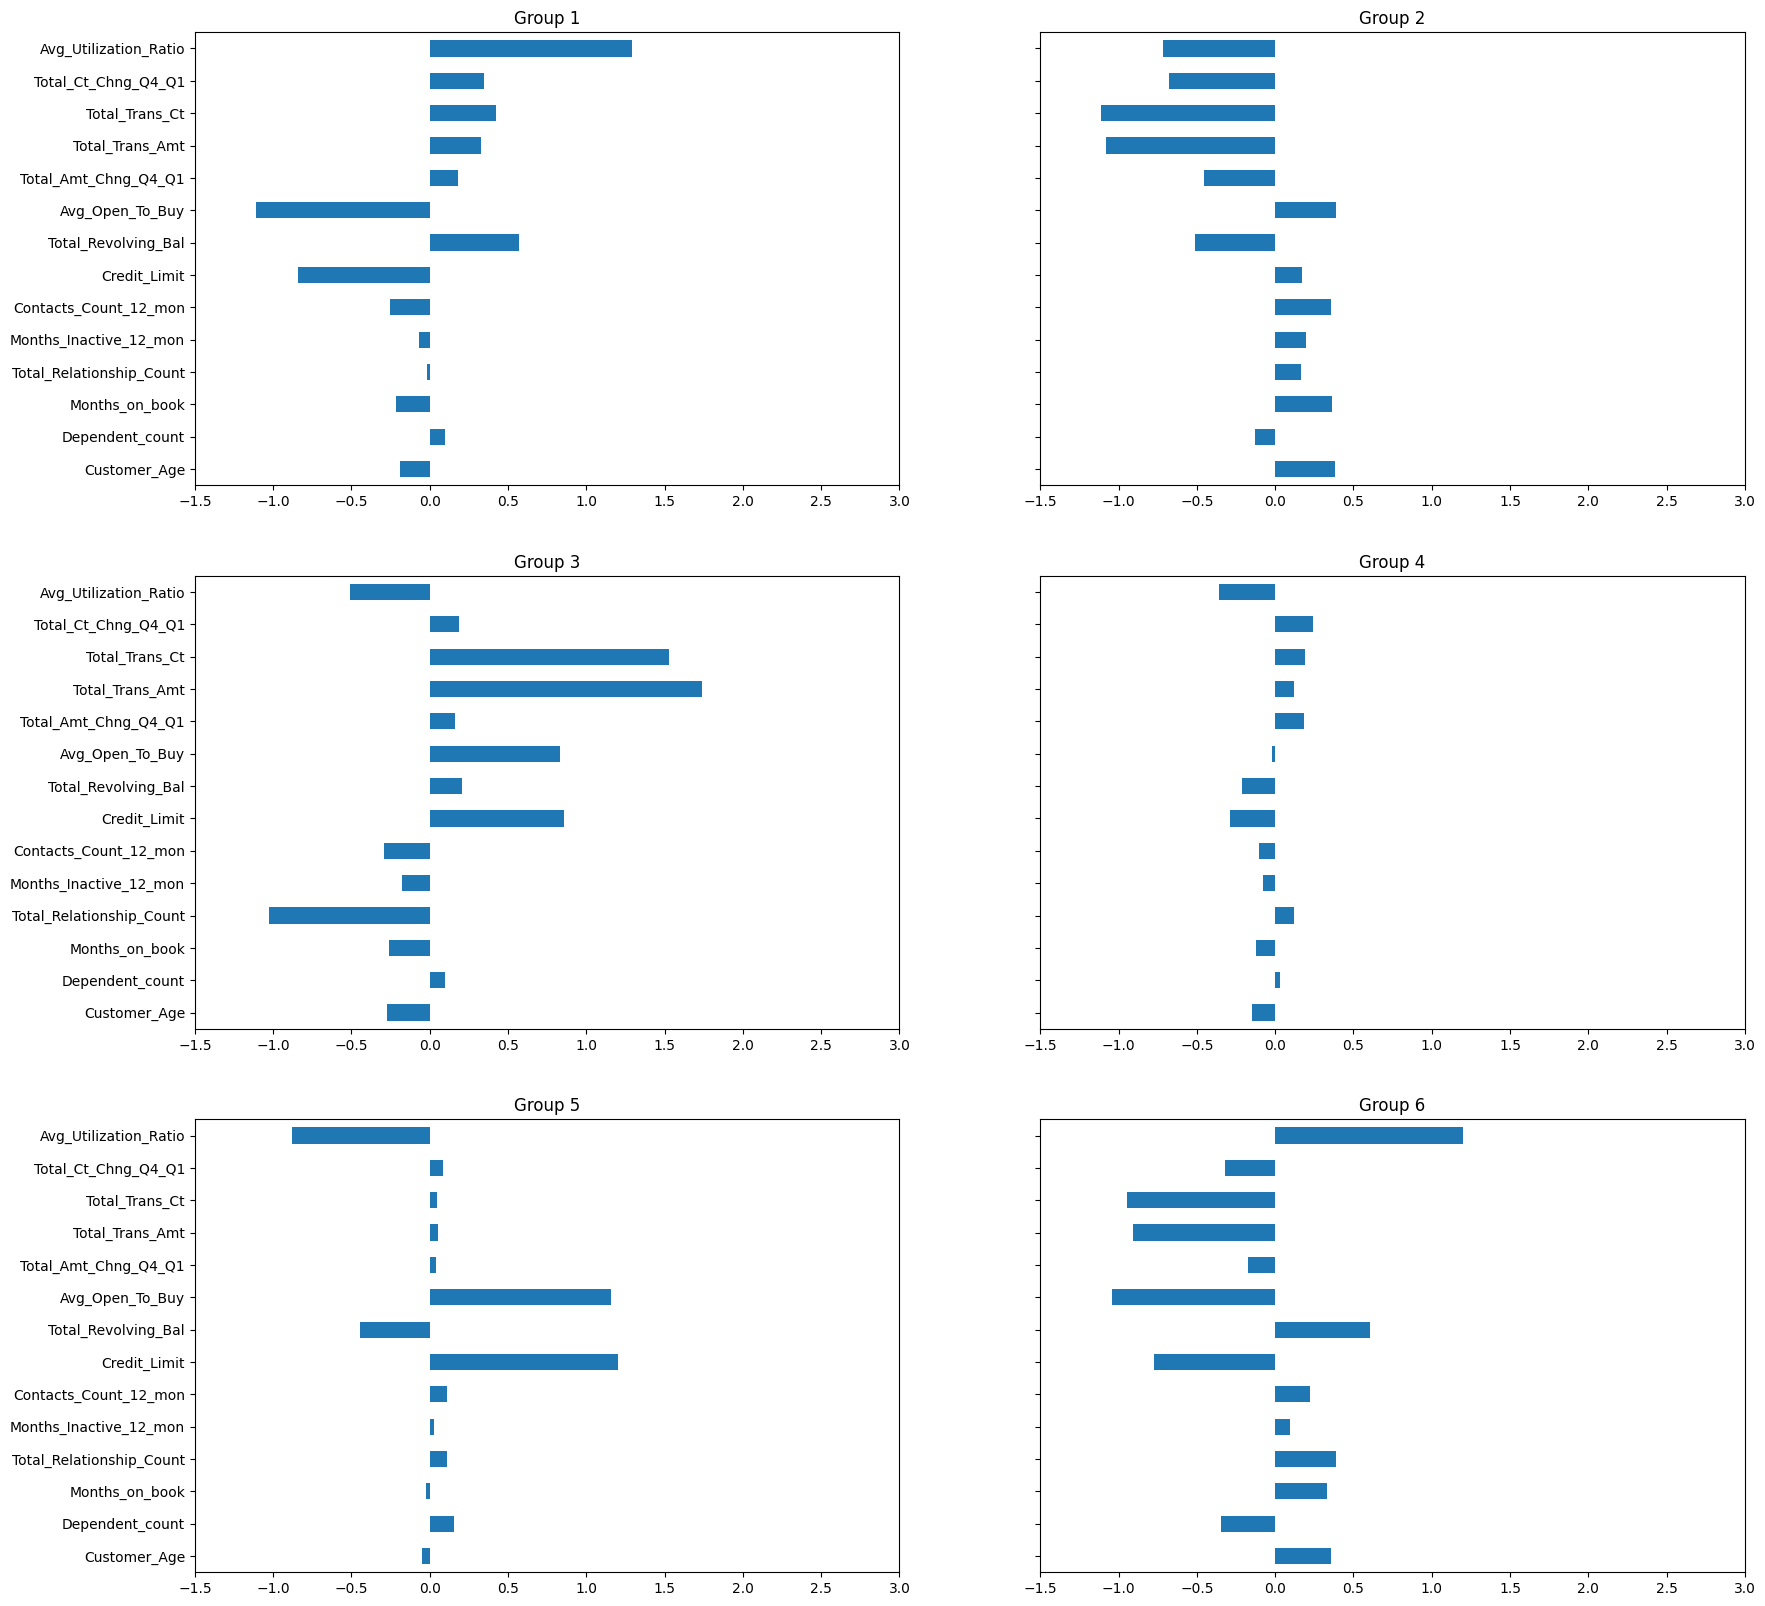

In [18]:
fix, axs = plt.subplots(ncols=2,nrows=3, figsize=(20,32))

scaled_df[scaled_df['cluster'] == 0][numeric_columns].mean().plot.barh(ax=axs[0,0], xlim=(-1.5, 3), figsize=(20,20), sharey=True, title='Group 1')
scaled_df[scaled_df['cluster'] == 1][numeric_columns].mean().plot.barh(ax=axs[0,1], xlim=(-1.5, 3), figsize=(20,20), sharey=True, title='Group 2')
scaled_df[scaled_df['cluster'] == 2][numeric_columns].mean().plot.barh(ax=axs[1,0], xlim=(-1.5, 3), figsize=(20,20), sharey=True, title='Group 3')
scaled_df[scaled_df['cluster'] == 3][numeric_columns].mean().plot.barh(ax=axs[1,1], xlim=(-1.5, 3), figsize=(20,20), sharey=True, title='Group 4')
scaled_df[scaled_df['cluster'] == 4][numeric_columns].mean().plot.barh(ax=axs[2,0], xlim=(-1.5, 3), figsize=(20,20), sharey=True, title='Group 5')
scaled_df[scaled_df['cluster'] == 5][numeric_columns].mean().plot.barh(ax=axs[2,1], xlim=(-1.5, 3), figsize=(20,20), sharey=True, title='Group 6')
plt.show()

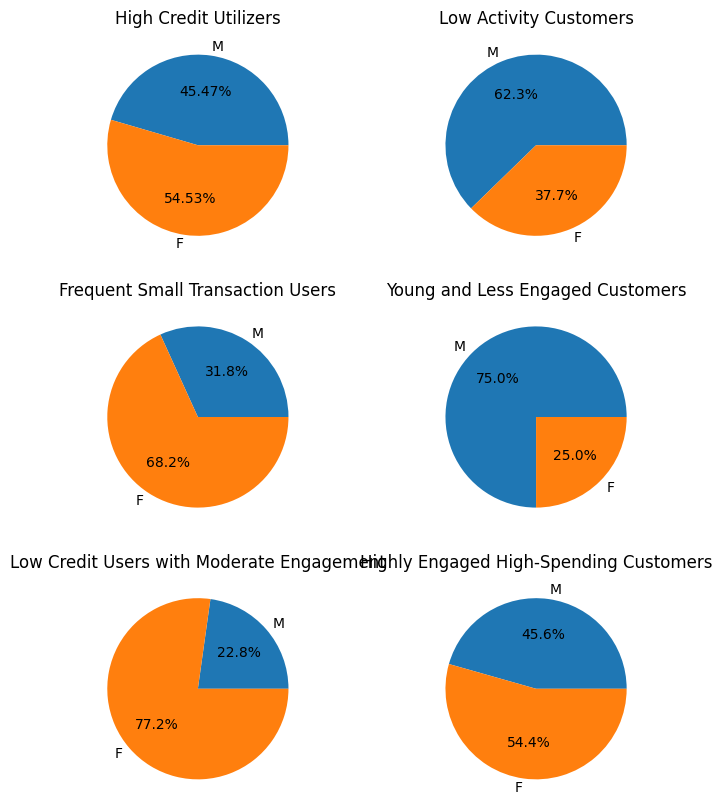

In [ ]:
fix, axs = plt.subplots(ncols=2,nrows=3, figsize=(8,10))

df[df['Cluster'] == 0]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,0], ylabel='', title='High Credit Utilizers', autopct='%.1f%%')
df[df['Cluster'] == 1]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,1], ylabel='', title='Low Activity Customers', autopct='%.1f%%')
df[df['Cluster'] == 2]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,0], ylabel='', title='Frequent Small Transaction Users', autopct='%.1f%%')
df[df['Cluster'] == 3]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,1], ylabel='', title='Young and Less Engaged Customers', autopct='%.1f%%')
df[df['Cluster'] == 4]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,0], ylabel='', title='Low Credit Users with Moderate Engagement', autopct='%.1f%%')
df[df['Cluster'] == 5]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,1], ylabel='', title='Highly Engaged High-Spending Customers', autopct='%.1f%%')
plt.show()